In [ ]:
!pip install gymnasium[atari] --quiet
!pip install gymnasium --quiet
!pip install -U gymnasium[atari] --quiet
!pip install imageio_ffmpeg --quiet
!pip install npy_append_array --quiet
!pip install pyTelegramBotAPI --quiet
!pip install gymnasium[accept-rom-license] --quiet
!pip install gymnasium[box2d] --quiet

In [41]:
import numpy as np 

class ExperienceReplayBuffer: 
    def __init__(self, max_memory, input_shape, n_actions): 
        self.mem_size = max_memory
        self.mem_counter = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                         dtype=np.float32)

        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_experience(self, state, action, reward, next_state, done): 
        index = self.mem_counter % self.mem_size 

        self.state_memory[index] = state
        self.new_state_memory[index] = next_state
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        self.mem_counter += 1
        

    def sample_experience(self, batch_size):
        max_mem = min(self.mem_counter, self.mem_size)
        batch_index = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch_index]
        next_states = self.new_state_memory[batch_index]
        rewards = self.reward_memory[batch_index]
        actions = self.action_memory[batch_index]
        terminal = self.terminal_memory[batch_index]

        return states, actions, rewards, next_states, terminal


In [43]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D, Input, Add, Lambda
from tensorflow.keras import backend as K


class DeepQNetwork2D(keras.Model):
    def __init__(self, input_dims, n_actions):
        super(DeepQNetwork2D, self).__init__()
     #   self.fc1 = Dense(64, activation='relu')
        self.fc1 = Dense(64, activation='relu')
        self.fc2 = Dense(64, activation='relu')
        
        self.value_output = Dense(1)
        self.advantage_output = Dense(n_actions)
        self.add = Add()

    def call(self, state):

        x = self.fc1(state)
        x = self.fc2(x)
        
        value_output = self.value_output(x)
        advantage_output = self.advantage_output(x)
        output = self.add([value_output, advantage_output])
        return output


class DeepQNetwork3D(keras.Model): 
    def __init__(self, input_dims, n_actions):
        super(DeepQNetwork3D, self).__init__()

        self.conv1 = Conv2D(32, 8, strides=(4, 4), activation='relu', data_format="channels_first", input_shape=input_dims)
        self.conv2 = Conv2D(32, 4, strides=(2, 2), activation='relu', data_format="channels_first")
        self.conv3 = Conv2D(64, 3, strides=(1, 1), activation='relu', data_format="channels_first")
        self.flatten = Flatten()

        self.fc2 = Dense(128, activation='relu')
        value_output = Dense(1)(backbone_2)
        advantage_output = Dense(self.action_dim)(backbone_2)
        output = Add()([value_output, advantage_output])


    def call(self, state):

        x = self.conv1(state)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        
        x = self.fc2(x)
        A = self.A(x)
        V = self.V(x)
        return V, A

In [44]:
import numpy as np

def epsilon_greedy_policy(q_val_network, observation, action_space, epsilon):
        if np.random.random() > epsilon:
            state = tf.convert_to_tensor([observation])
            actions = q_val_network.predict(state, verbose=0)
            action = tf.math.argmax(actions, axis=1).numpy()[0]
        else:
            action = np.random.choice(action_space)
        return action


def greedy_policy(observation, q_val_network, action_space): 
    state = tf.convert_to_tensor([observation])
    actions = q_val_network(state)
    action = tf.math.argmax(actions, axis=1).numpy()[0]
    return action


In [45]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam

#https://github.com/philtabor/Deep-Q-Learning-Paper-To-Code/blob/master/DQN/tf2/agent.py
class Agent: 
    def __init__(self, agent_params):
        # Parameters
        self.gamma = agent_params.get("gamma")
        self.lr = agent_params.get("lr")
        self.input_dims = agent_params.get("input_dims")
        self.batch_size = agent_params.get("batch_size")
        self.replace_target_weight_counter = agent_params.get("replace")
        self.algo = agent_params.get("algo")
        self.env_name = agent_params.get("env_name")
        self.chkpt_dir = agent_params.get("chkpt_dir")
        self.n_actions = agent_params.get("n_actions")
        self.action_space = agent_params.get('actions')
        
        self.eps = agent_params.get("eps")
        self.min_eps = agent_params.get("min_eps")
        self.eps_decay_rate = agent_params.get("eps_decay_rate")
        
        self.learn_step_counter = 0
        self.fname = self.chkpt_dir + self.env_name + '_' + self.algo + '_'
        self.mem_size = agent_params.get("mem_size")

        # networks and replaybuffer
        self.memory = ExperienceReplayBuffer(self.mem_size, self.input_dims, self.n_actions)
        self.q_value_network = DeepQNetwork2D(self.input_dims, self.n_actions) if len(self.input_dims) < 3 else \
                                                        DeepQNetwork3D(self.input_dims, self.n_actions)
        self.q_value_network.compile(optimizer=Adam(learning_rate=self.lr))
        self.target_q_network = DeepQNetwork2D(self.input_dims, self.n_actions) if len(self.input_dims) < 3 else \
                                                        DeepQNetwork3D(self.input_dims, self.n_actions)
        self.target_q_network.compile(optimizer=Adam(learning_rate=self.lr))

    def save_models(self):
        self.q_value_network.save(self.fname+'q_value')
        self.target_q_network.save(self.fname+'target_q')
        print('... models saved successfully ...')

    def load_models(self):
        self.q_value_network = keras.models.load_model(self.fname+'q_value')
        self.target_q_network = keras.models.load_model(self.fname+'target_q')
        print('... models loaded successfully ...')

    def store_experience(self, state, action, reward, state_, done):
        self.memory.store_experience(state, action, reward, state_, done)

    def sample_experience(self):
        state, action, reward, new_state, done = \
                                  self.memory.sample_experience(self.batch_size)
        states = tf.convert_to_tensor(state)
        rewards = tf.convert_to_tensor(reward)
        dones = tf.convert_to_tensor(done)
        actions = tf.convert_to_tensor(action, dtype=tf.int32)
        states_ = tf.convert_to_tensor(new_state)
        return states, actions, rewards, states_, dones

    def choose_action(self, observation):
        if np.random.random() > self.eps:
            state = tf.convert_to_tensor([observation])
            actions = self.q_value_network(state)
            action = tf.math.argmax(actions, axis=1).numpy()[0]
        else:
            action = np.random.choice(self.action_space)
        return action

    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_weight_counter == 0:
            self.target_q_network.set_weights(self.q_value_network.get_weights())
    
    def decrement_epsilon(self): 
        self.eps -= self.eps_decay_rate
        self.eps = max(self.eps, self.min_eps)

    def learn(self):
        if self.memory.mem_counter < self.batch_size:
            return

        self.replace_target_network()

        states, actions, rewards, states_, dones = self.sample_experience()
        rewards, actions, dones = rewards.numpy(), actions.numpy(), dones.numpy()

        with tf.GradientTape() as tape:
            q_pred = self.q_value_network(states)
            q_eval = self.target_q_network(states_)

            q_target = tf.identity(q_pred)
            q_target = q_target.numpy()
            q_eval = q_eval.numpy()


            batch_rewards = rewards
            batch_max_vals = np.array([self.gamma * max(val) for val in q_eval])
            batch_dones = [1 - int(done) for done in dones]

            q_target[[np.arange(self.batch_size)], actions] =  batch_rewards + batch_max_vals * batch_dones 

            loss = keras.losses.MSE(q_pred, q_target)

        params = self.q_value_network.trainable_variables
        grads = tape.gradient(loss, params)

        self.q_value_network.optimizer.apply_gradients(zip(grads, params))

        self.learn_step_counter += 1
        
        self.decrement_epsilon()

        
        return self.eps

In [46]:
import collections
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow as tf
from gymnasium.wrappers import *


def manage_memory():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)


def plot_learning_curve(scores, epsilons, filename, lines=None):
    x = [_ for _ in range(len(scores))]
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Training Steps", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)


def make_env(env_name, video_file_name, episode_freq_fo_video): 
    env = gym.make(env_name, render_mode="rgb_array")
    
    if len(env.observation_space.shape) >= 3: 
        #env = AtariPreprocessing(env, 10, 4, 84, False, True)
        env = ResizeObservation(env, 84)
        env = GrayScaleObservation(env, keep_dim=False)
        env = FrameStack(env, 4, lz4_compress=False)
        env = NormalizeObservation(env)

    return env

In [47]:
class Writer:
    def __init__(self, fname): 
        self.fname = fname 

    def write_to_file(self, content): 
        with open(self.fname, "a") as file: 
            file.write(content + "\n")

    def read_file(self, fname):
        with open(fname, "r") as file: 
            return file.read()
            

In [48]:
import time
from telebot import TeleBot
import datetime
import telebot

token = "6238487424:AAG0jRhvbiVa90qUcf2fAirQr_-quPMs7cU"
chat_id = "1055055706"
bot = TeleBot(token=token) 

def telegram_send(message, bot):
    chat_id = "1055055706"
    bot.send_message(chat_id=chat_id, text=message)

def welcome_msg(multi_step, double_dqn, dueling):
    st = 'Hi! Starting learning with DQN Multi-step = %d, Double DQN = %r, Dueling DQN = %r' % (multi_step, double_dqn, dueling)
    telegram_send(st, bot)
    
def info_msg(episode, max_episode, reward, best_score, loss): 
    st = f"Current Episode: {episode}, Current Reward: {reward}, Max Episode: {max_episode}, Best Score: {best_score}, loss: {loss}"
    telegram_send(st, bot)

def end_msg(learning_time):
    st = 'Finished! Learning time: ' + str(datetime.timedelta(seconds=int(learning_time)))
    telegram_send(st, bot)
    print(st)


In [49]:
import numpy as np 
import imageio


class RecordVideo: 
    
    def __init__(self, prefix_fname,  out_directory="videos/", fps=10): 
        self.prefix_fname = prefix_fname
        self.out_directory = out_directory
        self.fps = fps
        self.images = []
        
    def add_image(self, image): 
        self.images.append(image)
    
    def save(self, episode_no): 
        name = self.out_directory + self.prefix_fname + "_" + str(episode_no) + ".mp4"
        imageio.mimsave(name, [np.array(img) for i, img in enumerate(self.images)], fps=self.fps)
        self.images = []

In [50]:
from npy_append_array import NpyAppendArray
import numpy as np

class Trainer:   
    def __init__(self, env, trainer_params): 
       
        self.env = env 
        self.noe = trainer_params.get("noe")
        self.max_steps = trainer_params.get("max_steps")
       
        self.eps_decay_rate = trainer_params.get("eps_decay_rate")
        self.action_space = trainer_params.get("action_space")
        self.is_tg = trainer_params.get("is_tg")
        self.tg_bot_freq_epi = trainer_params.get("tg_bot_freq_epi")
        self.record = trainer_params.get("record")
        self.agent_params = {
                        "gamma":  trainer_params.get("gamma"), 
                        "lr":  trainer_params.get("lr"), 
                        "input_dims":  trainer_params.get("input_dims"),
                        "mem_size" :  trainer_params.get("mem_size"),
                        "batch_size" :  trainer_params.get("batch_size"),
                        "replace" :  trainer_params.get("replace"),
                        "algo" :  trainer_params.get("algo"),
                        "env_name" :  trainer_params.get("env_name"),
                        "n_actions" :  trainer_params.get("n_actions"),
                        "chkpt_dir":  trainer_params.get("chkpt_dir"),
                        "actions":  trainer_params.get("actions"),
                        "eps": trainer_params.get("eps"),
                        "min_eps": trainer_params.get("min_eps"),
                        "eps_decay_rate": trainer_params.get("eps_decay_rate"),
                        
                    }
        
        self.agent = Agent(self.agent_params)
        self.checkpoint = trainer_params.get("checkpoint")
        
        self.writer = Writer("model_training_results.txt")
        self.recorder = RecordVideo(trainer_params.get("video_prefix"), "videos/", 20)
        
        self.target_score = trainer_params.get("target_score")

    def train_rl_model(self): 
        episode_rewards = []
        epsilon_history = []
        avg_rewards = []
        best_reward = float("-inf")

        if self.checkpoint:
          self.agent.load_models()

        for episode in range(self.noe): 
            n_steps = 0 
            episodic_loss = 0
            state = self.env.reset()
            reward = 0 
            
            if self.record and episode%100==0: 
                img = self.env.render()
                self.recorder.add_image(img)

            for step in range(self.max_steps): 
                
                if self.record and episode%100==0: 
                    img = self.env.render()
                    self.recorder.add_image(img)

                if type(state) == tuple: 
                    state = state[0]
                state = state

                action = self.agent.choose_action(state)

                next_info = self.env.step(action)
                next_state, reward_prob, terminated, truncated, _ = next_info
                done = truncated or terminated
                reward += reward_prob

                self.agent.store_experience(state, action, reward_prob, next_state, done)
                eps = self.agent.learn()

                state = next_state
                n_steps += 1 
               
                
                if done: 
                    break

            epsilon_history.append(eps)
            episode_rewards.append(reward)
            avg_reward = np.mean(episode_rewards[-100:])
            avg_rewards.append(avg_reward)

            result = f"Episode: {episode}, Epsilon: {eps}, Steps: {n_steps}, Reward: {reward}, Best reward: {best_reward}, Avg reward: {avg_reward}"
            self.writer.write_to_file(result)
            print(result)
            
            # Saving Best Model
            if reward > best_reward: 
                best_reward = reward
                self.agent.save_models()
            
            # video Recorder
            if episode % 100 ==0:
                self.recorder.save(episode)
                
          # Telegram bot
            if self.is_tg and episode % self.tg_bot_freq_epi == 0: 
                info_msg(episode+1, self.noe, reward, best_reward, "d")
                
         # Eatly Stopping
            if episode > 100 and np.mean(episode_rewards[-100:]) >= self.target_score: 
                break
                
                
        return episode_rewards, epsilon_history, avg_rewards, best_reward

In [ ]:
import gymnasium as gym
import time

env = make_env("ALE/Pong-v5", "videos/", 50)
action_space = [_ for _ in range(env.action_space.n)]

episodic_rewards_filename = 'array_files/episodic_reward.npy'
epsilon_history_filename = 'array_files/epsilon_history.npy'
cum_avg_reward_filename = 'array_files/cum_avg_rewards.npy'
losses_filename = 'array_files/losses.npy'

agent_params = {
    "gamma": 0.99, 
    "lr": 0.001, 
    "input_dims": env.observation_space.shape,
    "mem_size" : 20000,
    "batch_size" : 32,
    "replace" : 1000,
    "algo" : "DQN",
    "env_name" : "pong-v5",
    "n_actions" : len(action_space),
    "chkpt_dir": "tmp/dqn/",
    "actions": action_space
}

trainer_params = {
    "noe": 50, 
    "max_steps": 10000,
    "max_eps": 1,
    "min_eps": 0.02,
    "eps_decay_rate": 1e-4,
    "eps": 1,
    "action_space": action_space,
    "is_tg": True,
    "tg_bot_freq_epi": 10,
    
}

if __name__ == "__main__": 
    try: 
        manage_memory()
        
        trainer = Trainer(agent, env, trainer_params)

        episode_rewards, avg_rewards, best_reward = trainer.train_rl_model()
    #    plot_learning_curve(episode_rewards, "plot_file")

       # eval_model(env, "keras model", "videos/", fps=10)
    
    except Exception as error:
        raise error


(8,)
Physical devices cannot be modified after being initialized
Episode: 0, Epsilon: 0.9996500000000016, Steps: 66, Reward: -93.09148340846082, Best reward: -inf, Avg reward: -93.09148340846082


... models saved successfully ...
Episode: 1, Epsilon: 0.9986400000000062, Steps: 101, Reward: -105.2511857933674, Best reward: -93.09148340846082, Avg reward: -99.17133460091411
Episode: 2, Epsilon: 0.9972900000000123, Steps: 135, Reward: -600.6154898378174, Best reward: -93.09148340846082, Avg reward: -266.3193863465486
Episode: 3, Epsilon: 0.9961300000000176, Steps: 116, Reward: -106.71273673242585, Best reward: -93.09148340846082, Avg reward: -226.41772394301788
Episode: 4, Epsilon: 0.9955400000000203, Steps: 59, Reward: -112.0739966879449, Best reward: -93.09148340846082, Avg reward: -203.5489784920033
Episode: 5, Epsilon: 0.9946200000000245, Steps: 92, Reward: -319.6103366406335, Best reward: -93.09148340846082, Avg reward: -222.89253818344164
Episode: 6, Epsilon: 0.9939400000000276, Steps: 68, Reward: -35.268680704297054, Best reward: -93.09148340846082, Avg reward: -196.08912997213528


... models saved successfully ...
Episode: 7, Epsilon: 0.992970000000032, Steps: 97, Reward: -190.8908382829972, Best reward: -35.268680704297054, Avg reward: -195.439343510993
Episode: 8, Epsilon: 0.9922100000000355, Steps: 76, Reward: -61.401516439883274, Best reward: -35.268680704297054, Avg reward: -180.54625161420304
Episode: 9, Epsilon: 0.9916100000000382, Steps: 60, Reward: -107.64795544761856, Best reward: -35.268680704297054, Avg reward: -173.2564219975446
Episode: 10, Epsilon: 0.9909200000000413, Steps: 69, Reward: -115.12260657869412, Best reward: -35.268680704297054, Avg reward: -167.97152968674
Episode: 11, Epsilon: 0.9899500000000457, Steps: 97, Reward: -168.19482827393074, Best reward: -35.268680704297054, Avg reward: -167.99013790233926
Episode: 12, Epsilon: 0.9892900000000487, Steps: 66, Reward: -97.25020634889454, Best reward: -35.268680704297054, Avg reward: -162.54860470592044
Episode: 13, Epsilon: 0.9884300000000527, Steps: 86, Reward: -342.42333500505777, Best rew

... models saved successfully ...
Episode: 29, Epsilon: 0.974290000000117, Steps: 97, Reward: -169.29899876394936, Best reward: 14.706329786765068, Avg reward: -182.09655085477183
Episode: 30, Epsilon: 0.9735800000001202, Steps: 71, Reward: -46.7828817055544, Best reward: 14.706329786765068, Avg reward: -177.73159378544221
Episode: 31, Epsilon: 0.9726200000001246, Steps: 96, Reward: -340.0337113229991, Best reward: 14.706329786765068, Avg reward: -182.8035349584909
Episode: 32, Epsilon: 0.971650000000129, Steps: 97, Reward: -90.06444893052725, Best reward: 14.706329786765068, Avg reward: -179.99325962431018
Episode: 33, Epsilon: 0.9704800000001343, Steps: 117, Reward: -103.64656352649041, Best reward: 14.706329786765068, Avg reward: -177.7477685626096
Episode: 34, Epsilon: 0.9697300000001378, Steps: 75, Reward: -202.30555082093144, Best reward: 14.706329786765068, Avg reward: -178.44941948427595
Episode: 35, Epsilon: 0.968570000000143, Steps: 116, Reward: -156.9234258924821, Best rewar

Episode: 100, Epsilon: 0.9063500000004262, Steps: 85, Reward: -68.56636730349933, Best reward: 14.706329786765068, Avg reward: -155.97706861560275
Episode: 101, Epsilon: 0.9057500000004289, Steps: 60, Reward: -155.70263236234769, Best reward: 14.706329786765068, Avg reward: -156.48158308129257
Episode: 102, Epsilon: 0.9051500000004317, Steps: 60, Reward: -79.46306616091087, Best reward: 14.706329786765068, Avg reward: -151.27005884452348
Episode: 103, Epsilon: 0.9045000000004346, Steps: 65, Reward: -94.89857544950803, Best reward: 14.706329786765068, Avg reward: -151.1519172316943
Episode: 104, Epsilon: 0.903550000000439, Steps: 95, Reward: -134.62456614108424, Best reward: 14.706329786765068, Avg reward: -151.3774229262257
Episode: 105, Epsilon: 0.9027800000004425, Steps: 77, Reward: -52.363646154471766, Best reward: 14.706329786765068, Avg reward: -148.7049560213641
Episode: 106, Epsilon: 0.9018100000004469, Steps: 97, Reward: -101.00433201748959, Best reward: 14.706329786765068, Avg

... models saved successfully ...
Episode: 194, Epsilon: 0.8166200000008346, Steps: 118, Reward: -116.78569774478473, Best reward: 36.68347804548469, Avg reward: -107.83340671638345
Episode: 195, Epsilon: 0.8158800000008379, Steps: 74, Reward: -78.76813956800225, Best reward: 36.68347804548469, Avg reward: -107.20008280561234
Episode: 196, Epsilon: 0.8148300000008427, Steps: 105, Reward: -96.84618966799795, Best reward: 36.68347804548469, Avg reward: -106.57448357540659
Episode: 197, Epsilon: 0.814110000000846, Steps: 72, Reward: -69.4195827367609, Best reward: 36.68347804548469, Avg reward: -106.63861667206103
Episode: 198, Epsilon: 0.8134100000008492, Steps: 70, Reward: -69.39867779969822, Best reward: 36.68347804548469, Avg reward: -106.46020200106945
Episode: 199, Epsilon: 0.8127200000008523, Steps: 69, Reward: -125.32441936736672, Best reward: 36.68347804548469, Avg reward: -106.77621269853867


Episode: 200, Epsilon: 0.8116000000008574, Steps: 112, Reward: -74.14395191167397, Best reward: 36.68347804548469, Avg reward: -106.8319885446204
Episode: 201, Epsilon: 0.8106300000008618, Steps: 97, Reward: -140.96503859777732, Best reward: 36.68347804548469, Avg reward: -106.68461260697471
Episode: 202, Epsilon: 0.8094200000008673, Steps: 121, Reward: -87.55424644946024, Best reward: 36.68347804548469, Avg reward: -106.7655244098602
Episode: 203, Epsilon: 0.8085400000008713, Steps: 88, Reward: -95.27418316301636, Best reward: 36.68347804548469, Avg reward: -106.76928048699529
Episode: 204, Epsilon: 0.8076400000008754, Steps: 90, Reward: -68.96274511321687, Best reward: 36.68347804548469, Avg reward: -106.1126622767166
Episode: 205, Epsilon: 0.8070500000008781, Steps: 59, Reward: -84.57425708708543, Best reward: 36.68347804548469, Avg reward: -106.43476838604276
Episode: 206, Epsilon: 0.8061200000008824, Steps: 93, Reward: -116.38065041505321, Best reward: 36.68347804548469, Avg rewar

Episode: 300, Epsilon: 0.7108200000013161, Steps: 87, Reward: -57.538304836932426, Best reward: 36.68347804548469, Avg reward: -85.73017336541935
Episode: 301, Epsilon: 0.7095000000013221, Steps: 132, Reward: -137.1341069667628, Best reward: 36.68347804548469, Avg reward: -85.69186404910918
Episode: 302, Epsilon: 0.7082900000013276, Steps: 121, Reward: -81.43462142984511, Best reward: 36.68347804548469, Avg reward: -85.63066779891305
Episode: 303, Epsilon: 0.7072600000013323, Steps: 103, Reward: -82.47002910696196, Best reward: 36.68347804548469, Avg reward: -85.50262625835252
Episode: 304, Epsilon: 0.706210000001337, Steps: 105, Reward: -118.57680689981528, Best reward: 36.68347804548469, Avg reward: -85.99876687621848
Episode: 305, Epsilon: 0.7053100000013411, Steps: 90, Reward: -86.79761955319887, Best reward: 36.68347804548469, Avg reward: -86.02100050087962
Episode: 306, Epsilon: 0.7039400000013474, Steps: 137, Reward: -53.61170778739227, Best reward: 36.68347804548469, Avg reward

Episode: 400, Epsilon: 0.6069200000017889, Steps: 84, Reward: -56.64343346379795, Best reward: 36.68347804548469, Avg reward: -78.70984802707103
Episode: 401, Epsilon: 0.606240000001792, Steps: 68, Reward: -65.0573066613638, Best reward: 36.68347804548469, Avg reward: -77.98908002401704
Episode: 402, Epsilon: 0.6053200000017962, Steps: 92, Reward: -61.51341401418895, Best reward: 36.68347804548469, Avg reward: -77.7898679498605
Episode: 403, Epsilon: 0.6043800000018005, Steps: 94, Reward: -134.4675195548169, Best reward: 36.68347804548469, Avg reward: -78.30984285433904
Episode: 404, Epsilon: 0.6035100000018044, Steps: 87, Reward: -73.30111200830679, Best reward: 36.68347804548469, Avg reward: -77.85708590542396
Episode: 405, Epsilon: 0.6024300000018094, Steps: 108, Reward: -122.02839609438021, Best reward: 36.68347804548469, Avg reward: -78.20939367083577
Episode: 406, Epsilon: 0.6014400000018139, Steps: 99, Reward: -89.6839729442661, Best reward: 36.68347804548469, Avg reward: -78.57

... models saved successfully ...
Episode: 471, Epsilon: 0.5022900000022651, Steps: 1000, Reward: -31.882409229030245, Best reward: 66.49234204341262, Avg reward: -55.23085872656846
Episode: 472, Epsilon: 0.5010200000022709, Steps: 127, Reward: 64.28201382178975, Best reward: 66.49234204341262, Avg reward: -54.200880329856965
Episode: 473, Epsilon: 0.4996700000022752, Steps: 135, Reward: -22.59623974672307, Best reward: 66.49234204341262, Avg reward: -54.154329259186134
Episode: 474, Epsilon: 0.498510000002274, Steps: 116, Reward: -53.869949077213825, Best reward: 66.49234204341262, Avg reward: -54.05553598167632
Episode: 475, Epsilon: 0.49704000000227255, Steps: 147, Reward: -99.34579363732428, Best reward: 66.49234204341262, Avg reward: -54.66267731891237
Episode: 476, Epsilon: 0.4947600000022703, Steps: 228, Reward: -22.187194647113927, Best reward: 66.49234204341262, Avg reward: -54.39498371283414
Episode: 477, Epsilon: 0.4933700000022689, Steps: 139, Reward: -98.15110444905517, Be

... models saved successfully ...
Episode: 490, Epsilon: 0.45856000000223407, Steps: 190, Reward: -27.63588711574188, Best reward: 69.77596247459333, Avg reward: -49.603771490320206
Episode: 491, Epsilon: 0.45694000000223245, Steps: 162, Reward: -144.74638015519065, Best reward: 69.77596247459333, Avg reward: -50.655379412435806
Episode: 492, Epsilon: 0.44694000000222245, Steps: 1000, Reward: 55.25017998654518, Best reward: 69.77596247459333, Avg reward: -50.010940092242784
Episode: 493, Epsilon: 0.43694000000221245, Steps: 1000, Reward: -8.160053057633599, Best reward: 69.77596247459333, Avg reward: -49.65304698517795
Episode: 494, Epsilon: 0.4351100000022106, Steps: 183, Reward: -26.894936505513925, Best reward: 69.77596247459333, Avg reward: -50.01555970286236
Episode: 495, Epsilon: 0.4251100000022006, Steps: 1000, Reward: 111.09055116379537, Best reward: 69.77596247459333, Avg reward: -47.87660971296155


... models saved successfully ...
Episode: 496, Epsilon: 0.42384000000219935, Steps: 127, Reward: -32.272804140664235, Best reward: 111.09055116379537, Avg reward: -47.48423728022378
Episode: 497, Epsilon: 0.4226000000021981, Steps: 124, Reward: -91.23471994220345, Best reward: 111.09055116379537, Avg reward: -47.47196225468777
Episode: 498, Epsilon: 0.42106000000219657, Steps: 154, Reward: -0.8203527845621181, Best reward: 111.09055116379537, Avg reward: -47.286559247769965
Episode: 499, Epsilon: 0.41953000000219504, Steps: 153, Reward: -43.05481125128692, Best reward: 111.09055116379537, Avg reward: -47.039828108809985
Episode: 500, Epsilon: 0.40953000000218504, Steps: 1000, Reward: 100.86455974307793, Best reward: 111.09055116379537, Avg reward: -45.46474817674123


Episode: 501, Epsilon: 0.4086100000021841, Steps: 92, Reward: -23.17287108474413, Best reward: 111.09055116379537, Avg reward: -45.045903820975035
Episode: 502, Epsilon: 0.40726000000218276, Steps: 135, Reward: -0.8092249625633059, Best reward: 111.09055116379537, Avg reward: -44.43886193045878
Episode: 503, Epsilon: 0.4062800000021818, Steps: 98, Reward: -46.2359921891832, Best reward: 111.09055116379537, Avg reward: -43.556546656802446
Episode: 504, Epsilon: 0.3962800000021718, Steps: 1000, Reward: 73.8656242497532, Best reward: 111.09055116379537, Avg reward: -42.084879294221835
Episode: 505, Epsilon: 0.3862800000021618, Steps: 1000, Reward: 70.5391774464996, Best reward: 111.09055116379537, Avg reward: -40.15920355881305
Episode: 506, Epsilon: 0.3852100000021607, Steps: 107, Reward: -39.98712199244079, Best reward: 111.09055116379537, Avg reward: -39.66223504929479
Episode: 507, Epsilon: 0.3752100000021507, Steps: 1000, Reward: 114.63946890305046, Best reward: 111.09055116379537, A

... models saved successfully ...
Episode: 508, Epsilon: 0.36837000000214387, Steps: 684, Reward: 237.73117237581158, Best reward: 114.63946890305046, Avg reward: -35.477698336460385


... models saved successfully ...
Episode: 509, Epsilon: 0.3657000000021412, Steps: 267, Reward: -24.38432380740582, Best reward: 237.73117237581158, Avg reward: -35.719080970118355
Episode: 510, Epsilon: 0.3557000000021312, Steps: 1000, Reward: 123.81447124525083, Best reward: 237.73117237581158, Avg reward: -34.27078495683702
Episode: 511, Epsilon: 0.3457000000021212, Steps: 1000, Reward: 123.11958918766645, Best reward: 237.73117237581158, Avg reward: -32.21609796444934
Episode: 512, Epsilon: 0.34386000000211936, Steps: 184, Reward: -115.36482315671174, Best reward: 237.73117237581158, Avg reward: -32.03040036587841
Episode: 513, Epsilon: 0.34226000000211776, Steps: 160, Reward: 3.985924646545797, Best reward: 237.73117237581158, Avg reward: -30.907304140519813
Episode: 514, Epsilon: 0.34057000000211607, Steps: 169, Reward: 10.778085922418597, Best reward: 237.73117237581158, Avg reward: -30.59492934439596
Episode: 515, Epsilon: 0.3359200000021114, Steps: 465, Reward: -111.736735878

... models saved successfully ...
Episode: 549, Epsilon: 0.10627000000190774, Steps: 695, Reward: 218.6736915554568, Best reward: 239.67828367560554, Avg reward: -17.25138684912146
Episode: 550, Epsilon: 0.1, Steps: 809, Reward: 207.9102593393255, Best reward: 239.67828367560554, Avg reward: -15.27316928380468
Episode: 551, Epsilon: 0.1, Steps: 1000, Reward: 98.26992825297552, Best reward: 239.67828367560554, Avg reward: -14.173758072677533
Episode: 552, Epsilon: 0.1, Steps: 660, Reward: 208.72225097846018, Best reward: 239.67828367560554, Avg reward: -11.481673431635123
Episode: 553, Epsilon: 0.1, Steps: 905, Reward: 100.72455370466716, Best reward: 239.67828367560554, Avg reward: -10.503014018792266
Episode: 554, Epsilon: 0.1, Steps: 296, Reward: -51.374605995967116, Best reward: 239.67828367560554, Avg reward: -10.487881160054632
Episode: 555, Epsilon: 0.1, Steps: 882, Reward: 248.66165952094283, Best reward: 239.67828367560554, Avg reward: -7.007104820173202


... models saved successfully ...
Episode: 556, Epsilon: 0.1, Steps: 506, Reward: 262.2915203200543, Best reward: 248.66165952094283, Avg reward: -4.566658206062045


... models saved successfully ...
Episode: 557, Epsilon: 0.1, Steps: 432, Reward: 280.1116527237653, Best reward: 262.2915203200543, Avg reward: -0.6382565041269856


... models saved successfully ...
Episode: 558, Epsilon: 0.1, Steps: 1000, Reward: -26.66116646288792, Best reward: 280.1116527237653, Avg reward: -0.6607032373104044
Episode: 559, Epsilon: 0.1, Steps: 684, Reward: 196.62947715552593, Best reward: 280.1116527237653, Avg reward: 1.8869988205745931
Episode: 560, Epsilon: 0.1, Steps: 1000, Reward: -36.73986013725411, Best reward: 280.1116527237653, Avg reward: 1.5888567378139558
Episode: 561, Epsilon: 0.1, Steps: 1000, Reward: 32.61767211595754, Best reward: 280.1116527237653, Avg reward: 1.6572272856089902
Episode: 562, Epsilon: 0.1, Steps: 912, Reward: 115.57010699819475, Best reward: 280.1116527237653, Avg reward: 3.2091558081775005
Episode: 563, Epsilon: 0.1, Steps: 1000, Reward: -31.856413829704785, Best reward: 280.1116527237653, Avg reward: 3.1275266276932028
Episode: 564, Epsilon: 0.1, Steps: 672, Reward: 160.00325911804794, Best reward: 280.1116527237653, Avg reward: 4.915383454002976
Episode: 565, Epsilon: 0.1, Steps: 938, Rewar

... models saved successfully ...
Episode: 574, Epsilon: 0.1, Steps: 1000, Reward: 93.13091338890918, Best reward: 290.6562753770295, Avg reward: 14.56623621702886
Episode: 575, Epsilon: 0.1, Steps: 620, Reward: 225.13171495354433, Best reward: 290.6562753770295, Avg reward: 17.81101130293755
Episode: 576, Epsilon: 0.1, Steps: 494, Reward: 221.45123804308042, Best reward: 290.6562753770295, Avg reward: 20.24739562983949
Episode: 577, Epsilon: 0.1, Steps: 861, Reward: 174.659236750344, Best reward: 290.6562753770295, Avg reward: 22.975499041833483
Episode: 578, Epsilon: 0.1, Steps: 1000, Reward: 93.46444298418554, Best reward: 290.6562753770295, Avg reward: 24.32562829063306
Episode: 579, Epsilon: 0.1, Steps: 466, Reward: 235.1867213879093, Best reward: 290.6562753770295, Avg reward: 27.09205176558432
Episode: 580, Epsilon: 0.1, Steps: 551, Reward: 215.12960821956693, Best reward: 290.6562753770295, Avg reward: 29.889635862237473
Episode: 581, Epsilon: 0.1, Steps: 896, Reward: 98.352500

Episode: 601, Epsilon: 0.1, Steps: 455, Reward: -67.1310813724539, Best reward: 290.6562753770295, Avg reward: 67.83806214196917
Episode: 602, Epsilon: 0.1, Steps: 540, Reward: 151.03818805703494, Best reward: 290.6562753770295, Avg reward: 69.35653627216517
Episode: 603, Epsilon: 0.1, Steps: 544, Reward: -205.04720961172578, Best reward: 290.6562753770295, Avg reward: 67.76842409793974
Episode: 604, Epsilon: 0.1, Steps: 299, Reward: 250.66198060136563, Best reward: 290.6562753770295, Avg reward: 69.53638766145586
Episode: 605, Epsilon: 0.1, Steps: 567, Reward: 247.43751462164784, Best reward: 290.6562753770295, Avg reward: 71.30537103320735
Episode: 606, Epsilon: 0.1, Steps: 1000, Reward: 75.02397357984213, Best reward: 290.6562753770295, Avg reward: 72.45548198893017
Episode: 607, Epsilon: 0.1, Steps: 412, Reward: 235.34964077628425, Best reward: 290.6562753770295, Avg reward: 73.66258370766252
Episode: 608, Epsilon: 0.1, Steps: 530, Reward: 257.6794422871805, Best reward: 290.656275

... models saved successfully ...
Episode: 661, Epsilon: 0.1, Steps: 726, Reward: 217.3651419119579, Best reward: 296.8337942618309, Avg reward: 169.6378504663344
Episode: 662, Epsilon: 0.1, Steps: 514, Reward: 231.49053871376776, Best reward: 296.8337942618309, Avg reward: 170.79705478349015
Episode: 663, Epsilon: 0.1, Steps: 288, Reward: 247.86779735009833, Best reward: 296.8337942618309, Avg reward: 173.5942968952882
Episode: 664, Epsilon: 0.1, Steps: 572, Reward: 237.4916980088972, Best reward: 296.8337942618309, Avg reward: 174.3691812841967
Episode: 665, Epsilon: 0.1, Steps: 386, Reward: 228.21189525169822, Best reward: 296.8337942618309, Avg reward: 178.66795212442543
Episode: 666, Epsilon: 0.1, Steps: 503, Reward: 238.38281519210707, Best reward: 296.8337942618309, Avg reward: 180.66365193761317
Episode: 667, Epsilon: 0.1, Steps: 322, Reward: 286.5737511629003, Best reward: 296.8337942618309, Avg reward: 181.91244244936584
Episode: 668, Epsilon: 0.1, Steps: 297, Reward: 229.916

... models saved successfully ...
Episode: 677, Epsilon: 0.1, Steps: 335, Reward: 278.9925284426955, Best reward: 300.28417064175994, Avg reward: 188.58793447060378
Episode: 678, Epsilon: 0.1, Steps: 277, Reward: 231.35234132939692, Best reward: 300.28417064175994, Avg reward: 189.96681345405588
Episode: 679, Epsilon: 0.1, Steps: 373, Reward: 254.69392917148846, Best reward: 300.28417064175994, Avg reward: 190.1618855318917
Episode: 680, Epsilon: 0.1, Steps: 328, Reward: 277.66679372412506, Best reward: 300.28417064175994, Avg reward: 190.78725738693728
Episode: 681, Epsilon: 0.1, Steps: 478, Reward: 275.2000182844415, Best reward: 300.28417064175994, Avg reward: 192.55573256394422
Episode: 682, Epsilon: 0.1, Steps: 558, Reward: 252.00695808673805, Best reward: 300.28417064175994, Avg reward: 195.41609288238703
Episode: 683, Epsilon: 0.1, Steps: 407, Reward: 254.247599436908, Best reward: 300.28417064175994, Avg reward: 196.14976774079943
Episode: 684, Epsilon: 0.1, Steps: 280, Reward:

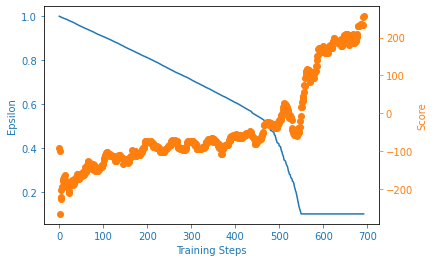

In [51]:
import gymnasium as gym
import time
import signal
import time
import sys
import pickle

env = make_env("LunarLander-v2", "videos/", 50)
action_space = [_ for _ in range(env.action_space.n)]
record = True
print( env.observation_space.shape)

trainer_params = {
    "noe": 1000, 
    "max_steps": 10000,
    "max_eps": 1,
    "min_eps": 0.1,
    "eps_decay_rate": 1e-5,
    "eps": 1,
    "action_space": action_space,
    "is_tg": True,
    "tg_bot_freq_epi": 10,
    "record": record,
    "gamma": 0.99, 
    "lr": 0.001, 
    "input_dims": env.observation_space.shape,
    "mem_size" : 100000,
    "batch_size" : 32,
    "replace" : 500,
    "algo" : "dueling_dqn",
    "env_name" : "lunarlander",
    "n_actions" : len(action_space),
    "chkpt_dir": "tmp/dueling_dqn/",
    "actions": action_space,
    "target_score": 200,
    "video_prefix": "dueling_dqn",
    "checkpoint": False
}

    
if __name__ == "__main__": 
    
    try: 
        manage_memory()
       
        trainer = Trainer(env, trainer_params)
        episode_rewards, epsilon_history, avg_rewards, best_reward = trainer.train_rl_model()
        
        with open("dueling_dqn_episode_rewards.obj", "wb") as f: 
            pickle.dump(episode_rewards, f)
        
        with open("dueling_dqn_epsilon_history.obj", "wb") as f: 
            pickle.dump(epsilon_history, f)
        
        with open("dueling_dqn_avg_rewards.obj", "wb") as f: 
            pickle.dump(avg_rewards, f)
            
        plot_learning_curve(episode_rewards, epsilon_history, "dueling_dqn")
        
    except Exception as error: 
        raise error
        
   # eval_model(env, "keras model", "videos/", fps=10)


In [60]:
import random 
import imageio
import tensorflow as tf 


class Eval: 

    def __init__(self, env, model_path, action_space, number_of_episode=50, test_video_path="test_videos/"):
        self.env = env 
        self.model = tf.keras.models.load_model(model_path)
        self.recorder = RecordVideo('dueling_dqn', test_video_path, 15)
        self.number_of_episode = number_of_episode
        self.action_space = action_space
        
    def test(self): 
        rewards = []
        steps = []
        for episode in range(self.number_of_episode): 
            done = False
            reward = 0
            step = 0
            state = env.reset(seed=random.randint(0,500))
            if episode % 1 == 0: 
                img = env.render()
                self.recorder.add_image(img) 

            while not done:
                if type(state) == tuple: 
                    state = state[0]
                    
                action =  greedy_policy(state, self.model, self.action_space)
                state, reward_prob, terminated, truncated, _ = env.step(action)
                done = terminated or truncated 
                reward += reward_prob
                step += 1 
                if episode % 1 == 0:
                    img = env.render()
                    self.recorder.add_image(img)
            
            rewards.append(reward)
            steps.append(step)
            self.recorder.save(1) if episode % 1 == 0 else None
        
        return rewards, steps                                                                                                                                                        


In [61]:
env = make_env("LunarLander-v2", "videos/", 50)
action_space = [_ for _ in range(env.action_space.n)]
model_path = "/content/tmp/dueling_dqn/lunarlander_dueling_dqn_q_value"

eval = Eval(env, model_path, action_space, 10)

In [62]:
test_rewards, steps = eval.test()

In [63]:
test_rewards

[138.8108153174976,
 225.6415642677828,
 278.19812668001833,
 265.09468033915107,
 257.81140068169685,
 244.87992382366315,
 225.04083347881598,
 249.0798702548756,
 233.8856473910113,
 248.3651946892898]